<h1 class="header"><img class="logo" src="../images/socib_logo.png" width="200px"></h1>

<h3> STYLING NOTEBOOK (OPTIONAL)</h3>

In [5]:
from IPython.core.display import HTML
import urllib2
HTML(urllib2.urlopen('https://raw.githubusercontent.com/socib/API_examples/master/style/custom/custom.css').read())

<h3> HANDY PYTHON PACKAGES </h3>

In [2]:
import requests
import json
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from json2html import *
from IPython.display import HTML, display
from matplotlib import colors
import shapely
from shapely.geometry import box
from matplotlib.patches import Polygon
%matplotlib inline

<h3> PREREQUISITES </h3>

In [3]:
api_key = '' #write you SOCIB api_key
api_url = 'http://api.socib.es'
headers = {
    'accept': 'application/vnd.socib+json',
    'apikey': api_key,
}

<h3> REQUESTING A DATA-SOURCE'S DATA </h3>

Let's look for deployments active during a certain time range in a defined area, involving a certain platform type and measuring a certain variable:

In [263]:
time_range_start = '2014-07-01T00:00:00' # should match the notation YYYY-MM-DDTHH:MM:SS
time_range_end =  '2014-12-01T00:00:00' # should match the notation YYYY-MM-DDTHH:MM:SS
min_lat = 40.0#float
max_lat = 38.0 #float
min_lon = 0.0 #float
max_lon = 3.0#float
bbox = str(min_lat)+','+str(max_lat)+','+str(min_lon)+','+str(max_lon)
platform_type = 'Surface drifter'
variables = 'sea_water_temperature'

In [264]:
end_point = '/data-sources/'
url_addons = '?platform_type=%s&initial_datetime=%s&end_datetime=%s&standard_variable=%s&bbox=%s'%(platform_type,time_range_start,time_range_end, variables,bbox)
request = requests.get('%s%s%s' % (api_url, end_point,url_addons), headers=headers)
response = json.loads(request.text)
print('Requested url: '+'%s%s%s' % (api_url, end_point,url_addons))
print(" ")
print('A total of %s SOCIB deployments match the above searching criteria'% (response['count']))

Requested url: http://api.socib.es/data-sources/?platform_type=Surface drifter&initial_datetime=2014-07-01T00:00:00&end_datetime=2014-12-01T00:00:00&standard_variable=sea_water_temperature&bbox=40.0,38.0,0.0,3.0
 
A total of 53 SOCIB deployments match the above searching criteria


Let's have a look to the metadata of one of the above deployments:

In [5]:
targeted_deployment = response['results'][4]#i.e deployment/data-source number 4 of the above page
metadata = {k:v for k, v in targeted_deployment.items() if k != 'entries'} #skipping the deployment data for later
HTML(json2html.convert(json=metadata))

From [What is a data-source?](what_is_a_data_source.ipynb) we know how to download, access and explore a given data-source/deployment netCDFs (thredds services available for the so-called entries) but in case of users prefer to overlook the underlying data format, SOCIB API offers an auxiliary endpoint: the <b>/data-sources/{id}/data</b>.<br> Let's target the above data-source by id:

In [42]:
end_point_plus_aux = '/data-sources/'+targeted_deployment['id']+'/data/'
request = requests.get('%s%s' % (api_url, end_point_plus_aux), headers=headers)
response = json.loads(request.text)
print('Requested url: '+'%s%s. Be aware of the id requested' % (api_url, end_point_plus_aux))

Requested url: http://api.socib.es/data-sources/e70d027340/data/. Be aware of the id requested


<h3>EXPLORING THE <span>/DATA-SOURCES/{ID}/DATA</span> AUXILIARY ENDPOINT <span>RESPONSE</span></h3>

Let's have a look to the available variables in the above data-source data:

In [44]:
for level in response.keys():
    variables_metadata = [{response[level]['features'][feature]['feature_type']: [{standard_variable: [{k:v for k, v in response[level]['features'][feature]['variables'][standard_variable][param].items() if k!='data'} for param in response[level]['features'][feature]['variables'][standard_variable].keys()]} for standard_variable in response[level]['features'][feature]['variables']]} for feature in range(0,len(response[level]['features']))]
    variables_per_level = {level: variables_metadata}
    display(HTML(json2html.convert(json=variables_per_level)))

Variables are grouped by:
<ul>
<li>processing levels: see all posible processing levels at [Quick start](../tips/quick_start.ipynb) </li>
<li>feature type : see all posible feature types at [Quick start](..tips/quick_start.ipynb) </li>
<li>standard name: see all posible processing standard names at [Quick start](..tips/quick_start.ipynb).<br> Be aware that when unknown standard name, they are grouped in '_NONE_'</li>
</ul>

For each of the above variables you have also access to the coordinates:

In [46]:
for level in response.keys():
    coords_metadata = [{response[level]['features'][feature]['feature_type']:[{coordinate: [{k:v for k, v in response[level]['features'][feature]['coordinates'][coordinate].items() if k!='data'}] for coordinate in response[level]['features'][feature]['coordinates'].keys()}]} for feature in range(0,len(response[level]['features']))]
    coords_per_level = {level: coords_metadata}
    display(HTML(json2html.convert(json=coords_per_level)))                     

<h3>FOCUSING ON A SPECIFIC VARIABLE - <span> REQUESTING A CERTAIN VARIABLE DATA </span> </h3>

As already shown in ['Searching for_certain data-sources'](searching_for_certain_data_sources.ipynb), there are parameters that added to an endpoint allows applying some filtering over the generic answer. In case of the <b>/data-sources/{id}/data</b> auxiliary endpoint we can, for example, restrict the generic answer (above) to a specific variable:

In [280]:
variables = 'sea_water_temperature'
end_point_plus_aux = '/data-sources/'+targeted_deployment['id']+'/data/'
url_addons = '?standard_variable='+variables
request = requests.get('%s%s%s' % (api_url, end_point_plus_aux,url_addons), headers=headers)
response = json.loads(request.text)
print('Requested url: '+'%s%s%s' % (api_url, end_point_plus_aux, url_addons))

Requested url: http://api.socib.es/data-sources/e70d027340/data/?standard_variable=sea_water_temperature


In [281]:
for level in response.keys():
    variables_metadata = [{response[level]['features'][feature]['feature_type']: [{standard_variable: [{k:v for k, v in response[level]['features'][feature]['variables'][standard_variable][param].items() if k!='data'} for param in response[level]['features'][feature]['variables'][standard_variable].keys()]} for standard_variable in response[level]['features'][feature]['variables']]} for feature in range(0,len(response[level]['features']))]
    variables_per_level = {level: variables_metadata}
    display(HTML(json2html.convert(json=variables_per_level)))

It is possible to narrow down even more and request the above variable from a specific procesing level:

In [331]:
variables = 'sea_water_temperature'
level = 'L1'
end_point_plus_aux = '/data-sources/'+targeted_deployment['id']+'/data/'
url_addons = '?standard_variable='+variables+'&processing_level='+level
request = requests.get('%s%s%s' % (api_url, end_point_plus_aux,url_addons), headers=headers)
response = json.loads(request.text)
print('Requested url: '+'%s%s%s' % (api_url, end_point_plus_aux, url_addons))

Requested url: http://api.socib.es/data-sources/e70d027340/data/?standard_variable=sea_water_temperature&processing_level=L1


In [332]:
for level in response.keys():
    variables_metadata = [{response[level]['features'][feature]['feature_type']: [{standard_variable: [{k:v for k, v in response[level]['features'][feature]['variables'][standard_variable][param].items() if k!='data'} for param in response[level]['features'][feature]['variables'][standard_variable].keys()]} for standard_variable in response[level]['features'][feature]['variables']]} for feature in range(0,len(response[level]['features']))]
    variables_per_level = {level: variables_metadata}
    display(HTML(json2html.convert(json=variables_per_level)))

<h3><span>PLOTTING THE DATA RETOURNED</span> BY THE /DATA-SOURCES/{ID}/DATA AUXILIARY ENDPOINT </h3>

In [318]:
def get_variable_matches(response, standard_name, level_type, feature_type):
    # explore a given /data-source/{id}/data/ response looking for a variable with a specific standard name,processing level and feature type
    level = response[level_type]
    features = [feature for feature in level['features'] if feature['feature_type'] == feature_type]
    variables = [feature['variables'][standard_name] for feature in features if standard_name in feature['variables'].keys()]
    matches = []
    for param in variables:
        for key in param.keys():
            try:
                matches.append({'units':param[key]['units'], 'data': param[key]['data']})
            except:
                matches.append({'units':'unknown', 'data': param[key]['data']})
    return matches;

In [319]:
def get_coordinate(response, name, level_type, feature_type):
    # explore a given /data-source/{id}/data/ response looking for a coordinate with a specific standard name,processing level and feature type
    level = response[level_type]
    features = [feature for feature in level['features'] if feature['feature_type'] == feature_type]
    coords = [feature['coordinates'][name] for feature in features if name in feature['coordinates'].keys()]
    matches = []
    for param in coords:
        try:
            matches.append({'units':param['units'], 'data': param['data']})
        except:
            matches.append({'units': 'unknown', 'data': param['data']})    
    return matches;

Set variables and coordinates:

In [323]:
variable_name = 'sea_water_temperature'
coord_name_1 = 'latitude'
coord_name_2 = 'longitude'

In [324]:
var = get_variable_matches(response, variable_name,'L1','trajectory')[0]
lat = get_coordinate(response, coord_name_1,'L1','trajectory')[0]
lon = get_coordinate(response, coord_name_2,'L1','trajectory')[0]

In [325]:
lat = np.array(lat['data'],dtype=float)
lon = np.array(lon['data'],dtype=float)

Plot overall trajectory:

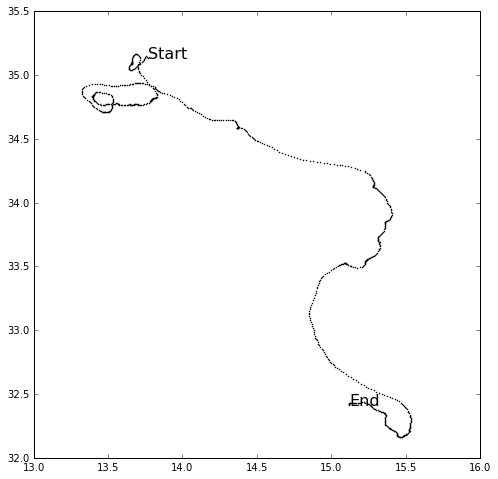

In [326]:
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111)
plt.plot(lon, lat, 'ko', ms=1)
plt.text(lon[0], lat[0], 'Start', fontsize=16)
plt.text(lon[-1], lat[-1], 'End', fontsize=16)
plt.show()

Detailed view:

In [329]:
lonmin, lonmax = ax.get_xlim()
latmin, latmax = ax.get_ylim()
cmap = plt.cm.Spectral_r
norm = colors.Normalize(vmin=min(var['data']), vmax=max(var['data']))

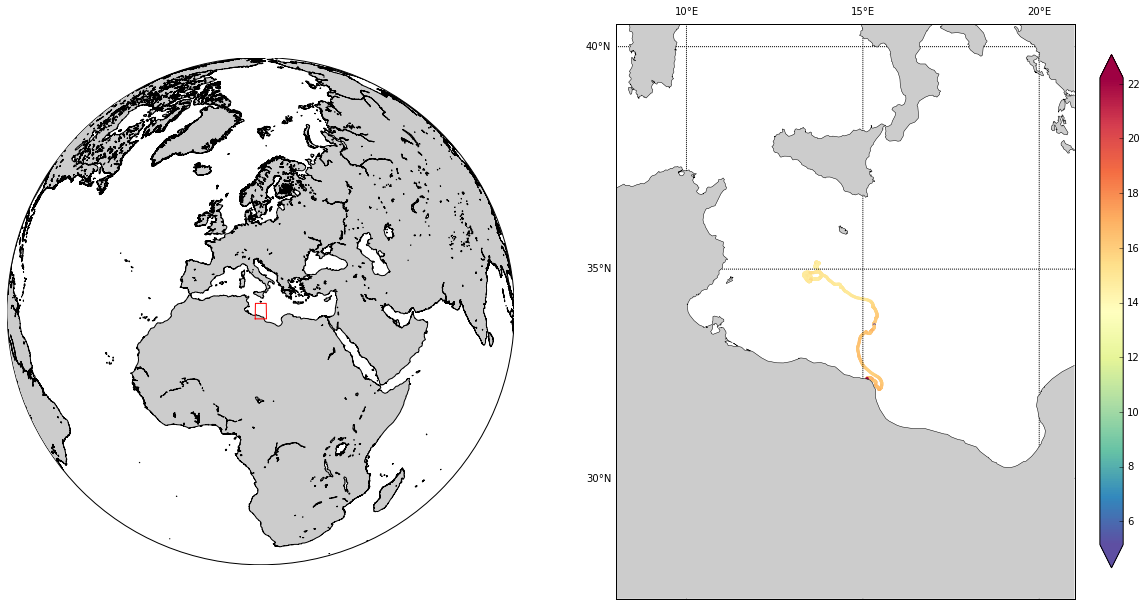

In [330]:
fig = plt.figure(figsize=(20,20))

ax = fig.add_subplot(122)
m = Basemap(projection='merc', llcrnrlat=latmin-5, urcrnrlat=latmax+5,
            llcrnrlon=lonmin-5, urcrnrlon=lonmax+5, lat_ts=20, resolution='i')
lon2, lat2 = m(lon, lat)
m.scatter(lon2, lat2, s=10, c=var['data'], edgecolor='None', cmap=cmap, norm=norm)
m.drawcoastlines(linewidth=0.5, zorder=3)
m.fillcontinents(zorder=2)
m.drawparallels(np.arange(-90.,91.,5.), labels=[1,0,0,0], zorder=1)
m.drawmeridians(np.arange(-180.,181.,5.), labels=[0,0,1,0], zorder=1)
plt.colorbar(fraction=0.046, extend='both', cmap=cmap, norm=norm)

ax = fig.add_subplot(121)
bounding_box = shapely.geometry.box(lonmin, latmin, lonmax, latmax)
x = bounding_box.centroid.x
y = bounding_box.centroid.y
map = Basemap(projection='ortho',lat_0=y, lon_0=x,resolution='i')
map.drawmapboundary()
map.fillcontinents()
map.drawcoastlines()
xs = [lonmin,lonmax,lonmax,lonmin,lonmin]
ys = [latmin,latmin,latmax,latmax,latmin]
map.plot(xs, ys,latlon = True, color='red')
plt.show()

<h3> WHAT ELSE?</h3>

<ul>
<li><b>SUBSETTING A DATA-SOURCE'S DATA</b> <br><br>If you want to know more about how to subset a given data-source's data overlooking the netCDF format, please have a look at the [Example 4](subsetting_a_data_sources_data.ipynb) ('Subsetting a data-source's data'), where it is explained how to use query parameters over the API auxiliary endpoints to subset a deployments data.</li>
<br>
<li><b>RESAMPLING A DATA-SOURCE'S DATA</b> <br><br>If you want to know more about how to resample a given data-source's data overlooking the netCDF format, please have a look at the [Example 5](resampling_a_data_sources_data.ipynb) ('Resampling a data-source's data'), where it is explained how to use query parameters over the API auxiliary endpoints to resample a deployments data.</li>
</ul>